In [1]:
###  Part 1 code, figures and explanatory text goes here and in subsequent cells. Show all code.
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np

In [2]:
# reload our adata 
adata2 = sc.read("adHW2.h5ad")

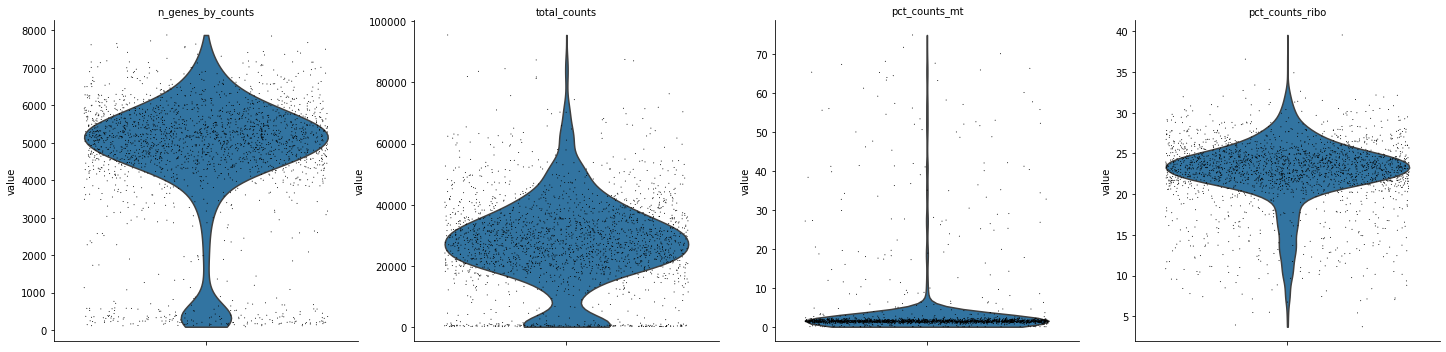

In [3]:
# id ribo and mt genes and score
adata2.var['mt']= adata2.var_names.str.startswith(("mt-"))
adata2.var['ribo'] = adata2.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adata2, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
axs = sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

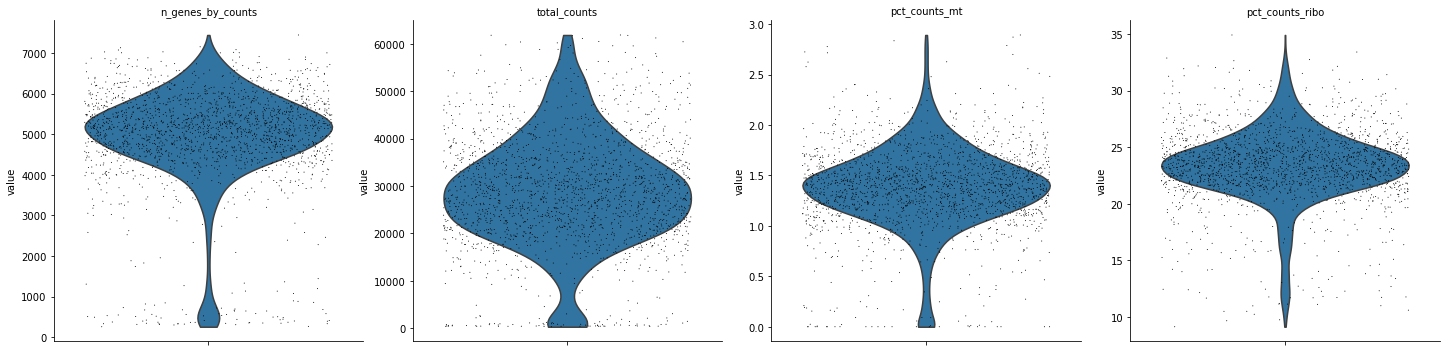

In [4]:
# remove bad cells, slightly different ribo threshold based on above violin plots, still 2% for doublets based off 10x rec
thresh = np.percentile(adata2.obs['total_counts'],98)
adata2 = adata2[adata2.obs['total_counts'] < thresh, :]
adata2 = adata2[adata2.obs['pct_counts_mt'] < 3, :]
adata2 = adata2[adata2.obs['pct_counts_ribo'] < 35, :]
axs = sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

In [5]:
# remove bad genes that are expressed in less than 5 cells
gThresh = 5
sc.pp.filter_genes(adata2, min_cells=gThresh)

Trying to set attribute `.var` of view, copying.


In [6]:
# get mt, ribo genes and Malat1 for removal
mito_genes = adata2.var_names.str.startswith('mt-')
ribo_genes = adata2.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adata2.var_names.str.startswith("Malat1")

# remove em
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)

keep = np.invert(remove)

# number of genes we are removing
print(len(keep) - np.count_nonzero(keep))

# remove these BAD genes
adata2 = adata2[:,keep].copy()
print("Number of genes: ", adata2.n_vars)

113
Number of genes:  16100


In [7]:
# normalize and log transform data
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)

In [8]:
# finding highly varaible genes 
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=4, min_disp=0.25)

In [9]:
# scaling the gene expression
sc.pp.scale(adata2, max_value=10)

In [10]:
# computate dimensional reduction. PCA 
sc.tl.pca(adata2, n_comps=100)

<AxesSubplot:xlabel='PC1', ylabel='PC4'>

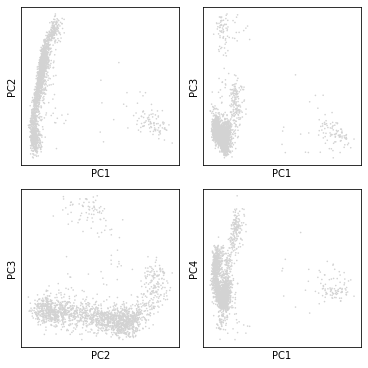

In [11]:
# show the PC plots
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata2, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata2, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata2, components="1,4", ax=axs[1,1], show=False, size=10)

In [12]:
# read in all gene lists
naive_genes = [x.strip() for x in open("genes_naive.csv")]
primed_genes = [x.strip() for x in open("genes_primed.csv")]
primitive_streak_genes = [x.strip() for x in open("genes_primitive_streak.csv")]
mesoderm_genes = [x.strip() for x in open("genes_mesoderm.csv")]
mef_genes = [x.strip() for x in open("genes_fibroblast.csv")]

In [13]:
# score them
sc.tl.score_genes(adata2, gene_list = naive_genes, score_name = "naive_genesets")
sc.tl.score_genes(adata2, gene_list = primed_genes, score_name = "primed_genesets")
sc.tl.score_genes(adata2, gene_list = primitive_streak_genes, score_name = "primitive_streak_genesets")
sc.tl.score_genes(adata2, gene_list = mesoderm_genes, score_name = "mesoderm_genesets")
sc.tl.score_genes(adata2, gene_list = mef_genes, score_name = "mef_genesets")

In [14]:
adata2.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230
AACAAGACAATGTTGC,350,436.0,74.0,16.972477,10.0,2.293578,-0.244778,1.872256,0.712677,1.919615,0.078509
AACCATGTCAAACGTC,6760,54390.0,12462.0,22.912300,704.0,1.294356,-0.013375,0.157211,0.804586,-0.276475,0.154296
AAGAACACAGACCGCT,4722,24134.0,3337.0,13.826966,255.0,1.056601,-0.816085,-0.790847,-0.783636,-0.307530,0.878109
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185
...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCGTAGAGGAA,4326,19656.0,5002.0,25.447699,320.0,1.628002,-0.058218,0.077178,1.065647,-0.290813,0.040322
TTTGGAGCAGGTTCCG,5024,28978.0,5820.0,20.084202,484.0,1.670233,1.390481,0.166589,-0.682212,-0.368295,-0.334538
TTTGGTTTCCGAAATC,5529,32798.0,7230.0,22.044027,448.0,1.365937,-0.382303,0.334571,1.319141,-0.113896,0.054865
TTTGTTGCATCGGCCA,5155,25648.0,5710.0,22.262945,321.0,1.251560,0.873649,-0.905697,-0.879065,-0.510326,0.291981


<AxesSubplot:title={'center':'mef_genesets'}, xlabel='PC1', ylabel='PC4'>

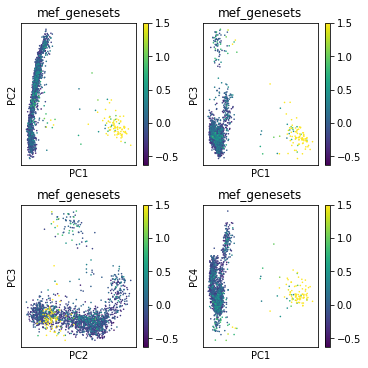

In [15]:
# plot pcas
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2, ax=axs[0,0], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2, components="1,3", ax=axs[0,1], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2, components="2,3", ax=axs[1,0], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2, components="1,4", ax=axs[1,1], color = "mef_genesets", show=False, size=10, vmax = 1.5)

In [16]:
# remove all cells with mef genesets < 0
# note: you should pick the threshold that works the best for your dataset. Unfortunately, there is no golden threshold 
adata2_refined = adata2[adata2.obs['mef_genesets'] < 0, :]

<AxesSubplot:title={'center':'mef_genesets'}, xlabel='PC1', ylabel='PC4'>

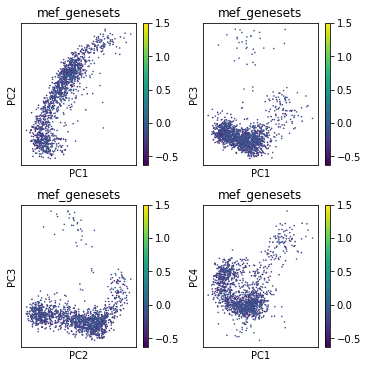

In [17]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "mef_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "mef_genesets", show=False, size=10, vmax = 1.5)

In [18]:
adata2_refined.obs # mefs removed

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185
AATCACGTCGACGACC,5920,51203.0,13795.0,26.941782,506.0,0.988223,1.180865,-0.918670,-0.720854,-0.226108,-0.167448
ACAAGCTAGTGTTCAC,6578,54268.0,13539.0,24.948404,979.0,1.804010,2.070385,-0.566424,-0.680331,-0.382433,-0.201345
ACATTTCCACCCAATA,494,669.0,138.0,20.627802,0.0,0.000000,-0.110276,-0.376076,-0.016581,0.353827,-0.058090
...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,6226,47202.0,11664.0,24.710817,746.0,1.580442,-0.553922,-0.035149,0.853431,-0.111625,-0.286409
TTTCGATTCCCAAGCG,5435,30923.0,7146.0,23.109013,398.0,1.287068,-0.832274,0.272020,0.785349,-0.468100,-0.022966
TTTGACTGTCACTTCC,5767,35729.0,7860.0,21.998936,538.0,1.505780,-0.604116,-0.717059,0.734134,4.251657,-0.161055
TTTGACTGTGCGGATA,4937,23234.0,5097.0,21.937677,326.0,1.403116,-0.396972,0.327058,1.400823,-0.116942,-0.196782


In [19]:
adata2_refined.write_h5ad('data_removeMEFs_after_clean.h5ad')

In [20]:
sum(adata2.obs['mef_genesets'] > 0) # # of mefs

521

In [21]:
# write the cell barcodes for the mef's to csv so we can remove them for part 6
pd.DataFrame(list(adata2[adata2.obs['mef_genesets'] > 0].obs.index)).to_csv('mef_cell_barcodes.csv')

In [22]:
mef_cell_barcodes = pd.read_csv('mef_cell_barcodes.csv', usecols=['0'])
mef_cell_barcodes['0']

0      AACAAGACAATGTTGC
1      AACCATGTCAAACGTC
2      AAGAACACAGACCGCT
3      AATTCCTCAGGACTTT
4      ACCCAAAAGATAACAC
             ...       
516    TTTGACTAGGCGTCCT
517    TTTGATCGTAGAGGAA
518    TTTGGTTTCCGAAATC
519    TTTGTTGCATCGGCCA
520    TTTGTTGCATGAGATA
Name: 0, Length: 521, dtype: object

In [23]:
# prepare unprocessed adata with mef cell barcodes removed for part 6
unprocessed_adata = sc.read_h5ad('adHW2.h5ad')
print(len(unprocessed_adata.obs))
# we want to keep cells that are not in mef cell barcodes and write the unprocessed no mef data to a new h5ad file for use in pt6
unprocessed_adata[~unprocessed_adata.obs.index.isin(mef_cell_barcodes['0'])].write_h5ad('unprocessed_data_no_mefs_pt6.h5ad')
# difference should be length of mef_cell_barcodes, 2201-1707 = 521
print(len(unprocessed_adata[~unprocessed_adata.obs.index.isin(mef_cell_barcodes['0'])]))

2201
1680


## let's try q3-5 with this data. This is out of order. Sorry to the TA's in advance for this unorganized work but my brain is starting to hurt. Code in the other sections was done without cleaning then removing the mefs. I removed the mefs first than cleaned. I left everything in here because I thought it could be interesting to compare the results. Really sorry for any headache this may cause!

In [24]:
# this is our processed, cleaned, data with mef's removed
adata2_refined.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185
AATCACGTCGACGACC,5920,51203.0,13795.0,26.941782,506.0,0.988223,1.180865,-0.918670,-0.720854,-0.226108,-0.167448
ACAAGCTAGTGTTCAC,6578,54268.0,13539.0,24.948404,979.0,1.804010,2.070385,-0.566424,-0.680331,-0.382433,-0.201345
ACATTTCCACCCAATA,494,669.0,138.0,20.627802,0.0,0.000000,-0.110276,-0.376076,-0.016581,0.353827,-0.058090
...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,6226,47202.0,11664.0,24.710817,746.0,1.580442,-0.553922,-0.035149,0.853431,-0.111625,-0.286409
TTTCGATTCCCAAGCG,5435,30923.0,7146.0,23.109013,398.0,1.287068,-0.832274,0.272020,0.785349,-0.468100,-0.022966
TTTGACTGTCACTTCC,5767,35729.0,7860.0,21.998936,538.0,1.505780,-0.604116,-0.717059,0.734134,4.251657,-0.161055
TTTGACTGTGCGGATA,4937,23234.0,5097.0,21.937677,326.0,1.403116,-0.396972,0.327058,1.400823,-0.116942,-0.196782


<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

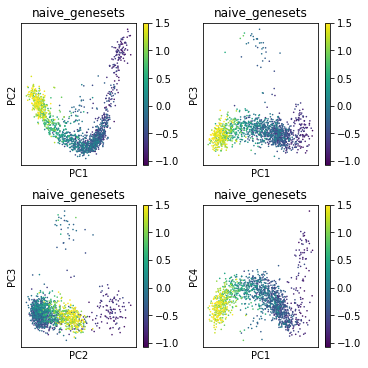

In [25]:
# computate dimensional reduction without the MEF's. PCA 
sc.tl.pca(adata2_refined, n_comps=100)

fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

In [26]:
# remove all cells with naive genesets < 0 
# note: you should pick the threshold that works the best for your dataset. Unfortunately, there is no golden threshold 
adata2_refined_naive = adata2_refined[adata2_refined.obs['naive_genesets'] < 0, :]

<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

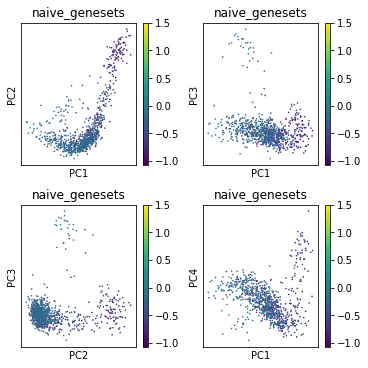

In [27]:
# you can see that the cells with high naive gene expressions are now removed 
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined_naive, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_naive, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_naive, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_naive, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

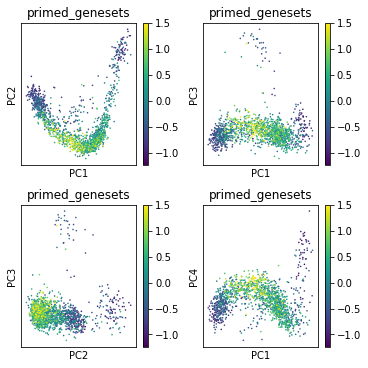

In [28]:
# plot pc's but with primed genesets
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

In [29]:
# remove all cells with primed genesets < 0 
# note: you should pick the threshold that works the best for your dataset. Unfortunately, there is no golden threshold 
adata2_refined_primed = adata2_refined[adata2_refined.obs['primed_genesets'] < 0, :]

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

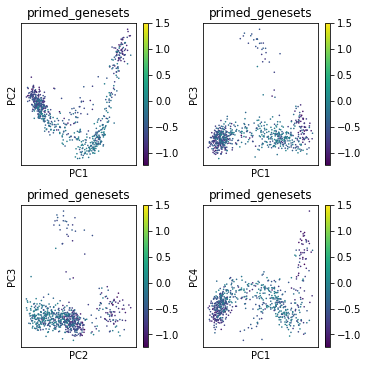

In [30]:
# plot pc's but with primed genesets removed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined_primed, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primed, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primed, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primed, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

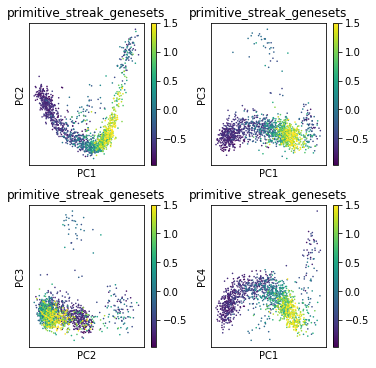

In [31]:
# plot pc's but with primitive streak genesets
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

In [32]:
# remove all cells with primitive streak genesets < 0 
# note: you should pick the threshold that works the best for your dataset. Unfortunately, there is no golden threshold 
adata2_refined_primitive_streak = adata2_refined[adata2_refined.obs['primitive_streak_genesets'] < 0, :]

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

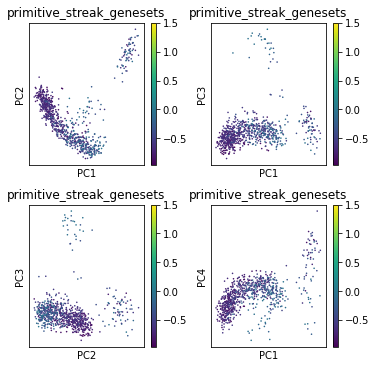

In [33]:
# plot pc's but with primitive streak genesets removed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined_primitive_streak, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primitive_streak, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primitive_streak, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_primitive_streak, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

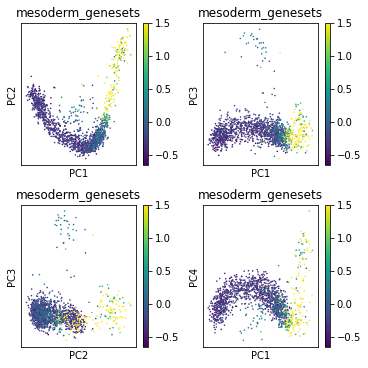

In [34]:
# plot pc's but with mesoderm genesets
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [35]:
# remove all cells with mesoderm genesets < 0 
# note: you should pick the threshold that works the best for your dataset. Unfortunately, there is no golden threshold 
adata2_refined_mesoderm = adata2_refined[adata2_refined.obs['mesoderm_genesets'] < 0, :]

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

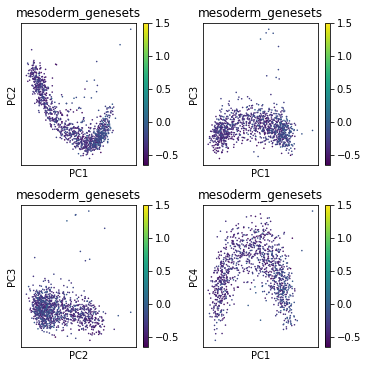

In [36]:
# plot pc's but with mesoderm genesets removed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined_mesoderm, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_mesoderm, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_mesoderm, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined_mesoderm, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [37]:
# performs KNN neighbors and then leiden clustering 
# note: there are no right or wrong parmaeters to choose when clustering. Just have to pick the ones that are reasonable and give reasonable results. 
# would highly suggest playing with the parameters and see how the results differ
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(adata2_refined, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [38]:
sc.tl.leiden(adata2_refined, .25)

In [39]:
adata2_refined.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets,leiden
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230,2
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185,2
AATCACGTCGACGACC,5920,51203.0,13795.0,26.941782,506.0,0.988223,1.180865,-0.918670,-0.720854,-0.226108,-0.167448,2
ACAAGCTAGTGTTCAC,6578,54268.0,13539.0,24.948404,979.0,1.804010,2.070385,-0.566424,-0.680331,-0.382433,-0.201345,2
ACATTTCCACCCAATA,494,669.0,138.0,20.627802,0.0,0.000000,-0.110276,-0.376076,-0.016581,0.353827,-0.058090,4
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,6226,47202.0,11664.0,24.710817,746.0,1.580442,-0.553922,-0.035149,0.853431,-0.111625,-0.286409,0
TTTCGATTCCCAAGCG,5435,30923.0,7146.0,23.109013,398.0,1.287068,-0.832274,0.272020,0.785349,-0.468100,-0.022966,0
TTTGACTGTCACTTCC,5767,35729.0,7860.0,21.998936,538.0,1.505780,-0.604116,-0.717059,0.734134,4.251657,-0.161055,3
TTTGACTGTGCGGATA,4937,23234.0,5097.0,21.937677,326.0,1.403116,-0.396972,0.327058,1.400823,-0.116942,-0.196782,0


<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC4'>

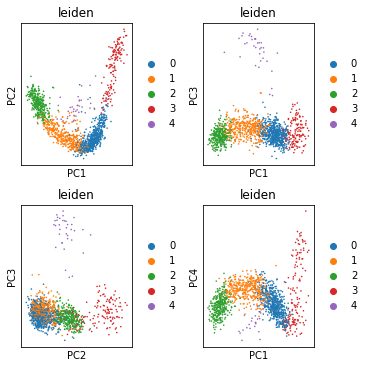

In [40]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "leiden", show=False, size=10, vmax = 1.5)

# the clusetrs here look like the correspond to the ones above but the purple one may be an outlier 
# naive is green 2
# primed is orange 1
# primitive is blue 0
# mesoderm is red 3

In [41]:
# making a new column in adata.obs dataframe and the assigning cell types
adata2_refined.obs['cell_type_label'] = None 
adata2_refined.obs.loc[adata2_refined.obs['leiden'] == '0', 'cell_type_label'] = 'Primitive'
adata2_refined.obs.loc[adata2_refined.obs['leiden'] == '1', 'cell_type_label'] = 'Primed'
adata2_refined.obs.loc[adata2_refined.obs['leiden'] == '2', 'cell_type_label'] = 'Naive'
adata2_refined.obs.loc[adata2_refined.obs['leiden'] == '3', 'cell_type_label'] = 'Mesoderm'
adata2_refined.obs.loc[adata2_refined.obs['leiden'] == '4', 'cell_type_label'] = 'Other'

... storing 'cell_type_label' as categorical


<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

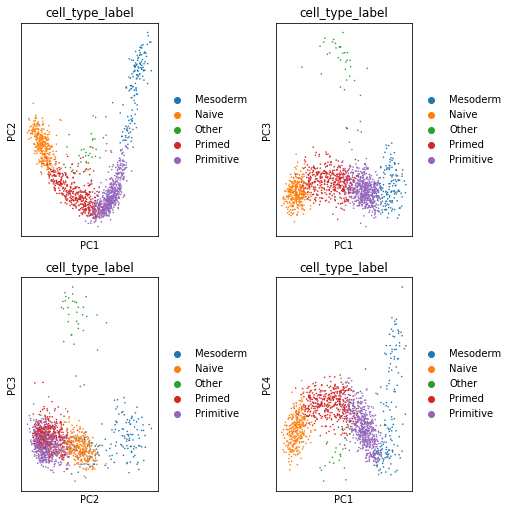

In [42]:
# replot with cell type classifiers, should be identical to previous plot but colors moved around
fig, axs = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [43]:
# get predicted cell type labels as a csv
adata2_refined.obs['cell_type_label'].to_csv('cell_types_TA_method_clean_b4_mef_removal.csv')

# get counts of each cell type
adata2_refined.obs['cell_type_label'].value_counts()

Primitive    562
Primed       403
Naive        321
Mesoderm     145
Other         35
Name: cell_type_label, dtype: int64

In [44]:
# remove each cell type individually and replot to confirm we got the right ones
refined_adata_nonaive = adata2_refined[adata2_refined.obs['cell_type_label'] != "Naive", :]
refined_adata_noprimed = adata2_refined[adata2_refined.obs['cell_type_label'] != "Primed", :]
refined_adata_noprimitive = adata2_refined[adata2_refined.obs['cell_type_label'] != "Primitive", :]
refined_adata_nomesoderm = adata2_refined[adata2_refined.obs['cell_type_label'] != "Mesoderm", :]

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

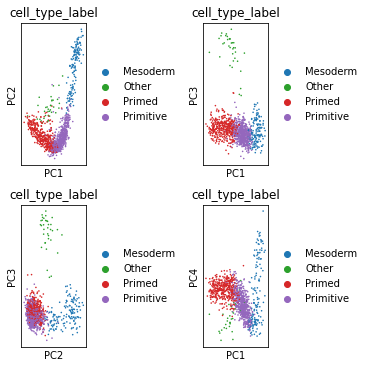

In [45]:
# no naive
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(refined_adata_nonaive, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nonaive, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nonaive, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nonaive, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

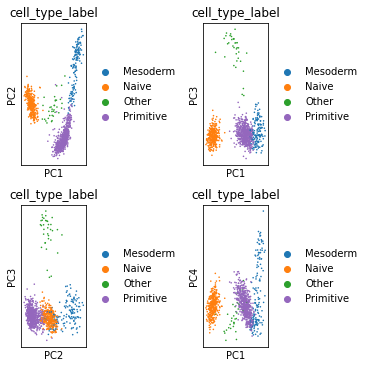

In [46]:
# no primed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(refined_adata_noprimed, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimed, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimed, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimed, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

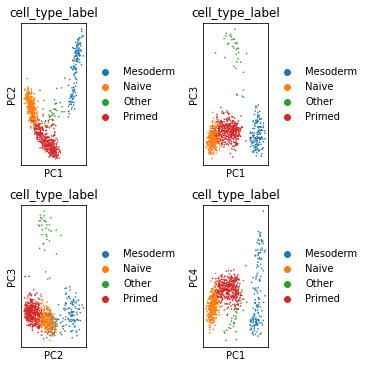

In [47]:
# no primitive
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(refined_adata_noprimitive, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimitive, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimitive, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_noprimitive, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

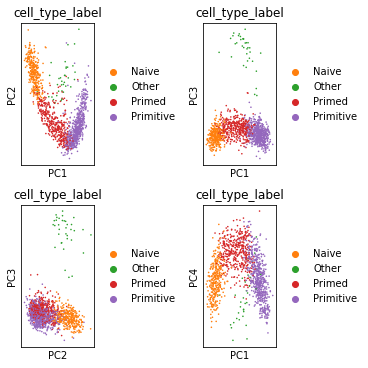

In [48]:
# no mesoderm
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(refined_adata_nomesoderm, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nomesoderm, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nomesoderm, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(refined_adata_nomesoderm, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [49]:
# q4 cell cycle prediction
# read in the cell cycle genes as a list
cell_cycle_genes = [x.strip() for x in open("mouseCellCycle_050218.csv")]

In [50]:
# classify cell cycle genes for each part of the cell cycle
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# now intersect these with genes present in the annData object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata2_refined.var_names]
print("n cc genes:", len(cell_cycle_genes))

n cc genes: 112


In [51]:
# reassign the genes for only the one present in the data, they all should be there tho
s_genes = [x for x in s_genes if x in adata2_refined.var_names]
g2m_genes = [x for x in g2m_genes if x in adata2_refined.var_names]

In [52]:
# score the genes based on these seperated cell cycle genes so we can make a pca 
sc.tl.score_genes_cell_cycle(adata2_refined, s_genes=s_genes, g2m_genes=g2m_genes)

In [53]:
adata2_refined.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets,leiden,cell_type_label,S_score,G2M_score,phase
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230,2,Naive,0.121245,-0.180180,S
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185,2,Naive,0.153964,0.117394,S
AATCACGTCGACGACC,5920,51203.0,13795.0,26.941782,506.0,0.988223,1.180865,-0.918670,-0.720854,-0.226108,-0.167448,2,Naive,-0.406983,0.231144,G2M
ACAAGCTAGTGTTCAC,6578,54268.0,13539.0,24.948404,979.0,1.804010,2.070385,-0.566424,-0.680331,-0.382433,-0.201345,2,Naive,-0.123072,0.221507,G2M
ACATTTCCACCCAATA,494,669.0,138.0,20.627802,0.0,0.000000,-0.110276,-0.376076,-0.016581,0.353827,-0.058090,4,Other,-0.146778,-0.585443,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,6226,47202.0,11664.0,24.710817,746.0,1.580442,-0.553922,-0.035149,0.853431,-0.111625,-0.286409,0,Primitive,-0.078648,-0.012066,G1
TTTCGATTCCCAAGCG,5435,30923.0,7146.0,23.109013,398.0,1.287068,-0.832274,0.272020,0.785349,-0.468100,-0.022966,0,Primitive,-0.211332,0.406195,G2M
TTTGACTGTCACTTCC,5767,35729.0,7860.0,21.998936,538.0,1.505780,-0.604116,-0.717059,0.734134,4.251657,-0.161055,3,Mesoderm,-0.284396,0.486331,G2M
TTTGACTGTGCGGATA,4937,23234.0,5097.0,21.937677,326.0,1.403116,-0.396972,0.327058,1.400823,-0.116942,-0.196782,0,Primitive,0.003583,-0.001892,S


In [54]:
# see how many cells are at each cell cycle stage
adata2_refined.obs['phase'].value_counts()

G2M    711
S      613
G1     142
Name: phase, dtype: int64

In [55]:
adata2_refined.obs['cell_type_label']

AAAGGATCATCAGCTA        Naive
AAGTTCGTCATCCTAT        Naive
AATCACGTCGACGACC        Naive
ACAAGCTAGTGTTCAC        Naive
ACATTTCCACCCAATA        Other
                      ...    
TTTCGATGTGCGAACA    Primitive
TTTCGATTCCCAAGCG    Primitive
TTTGACTGTCACTTCC     Mesoderm
TTTGACTGTGCGGATA    Primitive
TTTGGAGCAGGTTCCG        Naive
Name: cell_type_label, Length: 1466, dtype: category
Categories (5, object): ['Mesoderm', 'Naive', 'Other', 'Primed', 'Primitive']

In [56]:
print('S phase and Naive:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='S') & (adata2_refined.obs['cell_type_label'] == 'Naive')]))
print('S phase and Primed:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='S') & (adata2_refined.obs['cell_type_label'] == 'Primed')]))
print('S phase and Primitive:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='S') & (adata2_refined.obs['cell_type_label'] == 'Primitive')]))
print('S phase and Mesoderm:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='S') & (adata2_refined.obs['cell_type_label'] == 'Mesoderm')]))
print('S phase and Other:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='S') & (adata2_refined.obs['cell_type_label'] == 'Other')]))

print('G2M phase and Naive:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='G2M') & (adata2_refined.obs['cell_type_label'] == 'Naive')]))
print('G2M phase and Primed:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='G2M') & (adata2_refined.obs['cell_type_label'] == 'Primed')]))
print('G2M phase and Primitive:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='G2M') & (adata2_refined.obs['cell_type_label'] == 'Primitive')]))
print('G2M phase and Mesoderm:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='G2M') & (adata2_refined.obs['cell_type_label'] == 'Mesoderm')]))
print('G2M phase and Other:',len(adata2_refined.obs[(adata2_refined.obs['phase'] =='G2M') & (adata2_refined.obs['cell_type_label'] == 'Other')]))

S phase and Naive: 136
S phase and Primed: 184
S phase and Primitive: 238
S phase and Mesoderm: 48
S phase and Other: 7
G2M phase and Naive: 159
G2M phase and Primed: 193
G2M phase and Primitive: 270
G2M phase and Mesoderm: 78
G2M phase and Other: 11


... storing 'phase' as categorical


<AxesSubplot:title={'center':'phase'}, xlabel='PC1', ylabel='PC4'>

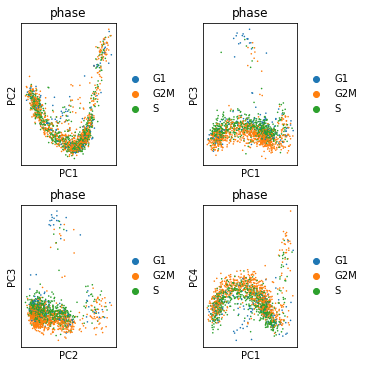

In [57]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined, ax=axs[0,0], color = "phase", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,3", ax=axs[0,1], color = "phase", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="2,3", ax=axs[1,0], color = "phase", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined, components="1,4", ax=axs[1,1], color = "phase", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

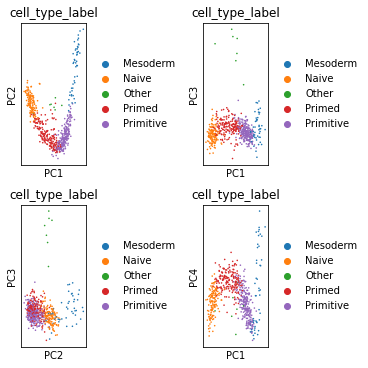

In [58]:
# pca's of cells in S phase
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'S'], ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'S'], components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'S'], components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'S'], components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

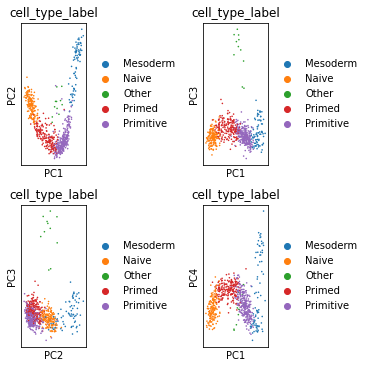

In [59]:
# pca's of cells in G2M phase
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'G2M'], ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'G2M'], components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'G2M'], components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata2_refined[adata2_refined.obs['phase'] == 'G2M'], components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [60]:
# now we want to write a function that goes through all the columns (genes) in adata_x_df and runs pearcorr vs s and g2m scores in adata.obs
# returns a dictionary with genes asosciated with cell cycle phases S and G2M
# can specify the pearcorr threshold and whether we want novel genes only or not
def get_cc_genes(adata, given_cc_genes = [], pthresh = 0.45, novel = True):
    # convert adata.X to a df with column names as genes and index as cell labels so it can easily be compared to adata.obs and adata.vars
    adata_x_df = adata.to_df()
    
    # dictionary to store all identified cc genes
    found_cc_genes = {'S': [], 'G2M': []} # is it possible for a gene to associated with both ?
    
    # here we iterate through all the genes and perform pearcorr
    # add all the ones that are above the threshold for each phase of the cell cycle
    for gene in list(adata_x_df.columns):

        if(sp.stats.pearsonr(adata_x_df[gene], adata.obs['S_score'])[0] > pthresh): # index zero to get pearson coeff
            found_cc_genes['S'].append(gene)

        if(sp.stats.pearsonr(adata_x_df[gene], adata.obs['G2M_score'])[0] > pthresh): # index zero to get pearson coeff
            found_cc_genes['G2M'].append(gene)
        
    
    if novel:
        # only keep the ones that are NOT in the predefined list
        found_cc_genes['S'] = list(set(found_cc_genes['S']) - set(given_cc_genes))
        found_cc_genes['G2M'] = list(set(found_cc_genes['G2M']) - set(given_cc_genes))

    return found_cc_genes

In [61]:
# run our function with novel true and false
novel_cc_genes = get_cc_genes(adata2_refined, cell_cycle_genes, novel = True)
found_cc_genes = get_cc_genes(adata2_refined, cell_cycle_genes, novel = False)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [62]:
# check to see if there is any overlap, outputs the overlap
list(set(found_cc_genes['S']) & set(found_cc_genes['G2M']))

[]

In [63]:
# check to see if there is any overlap, outputs the overlap
list(set(novel_cc_genes['S']) & set(novel_cc_genes['G2M']))

[]

In [64]:
found_cc_genes # all found cc genes above the pearson corr threshold of 0.45

{'S': ['Mcm6',
  'Cdc6',
  'Rrm2',
  'Chaf1b',
  'Pcna',
  'Rpa2',
  'Ung',
  'Ccne1',
  'Mcm5',
  'Tipin'],
 'G2M': ['Cenpf',
  'Sgo2a',
  'Cdk1',
  'Hmmr',
  'Top2a',
  'Jpt1',
  'Aurkb',
  'Birc5',
  'Mis18bp1',
  'Ccnb1',
  'Cks2',
  'Cdca2',
  'Racgap1',
  'Tuba1c',
  'Ccnf',
  'Kif20a',
  'Incenp',
  'Kif20b',
  'Kif11',
  'Tubb4b',
  'Ckap2l',
  'Aurka',
  'Nusap1',
  'Tpx2',
  'Fam83d',
  'Ube2c',
  'Smc4',
  'Cenpe',
  'Kif2c',
  'Cdc20',
  'Cdca8',
  'Smc2',
  'Dbf4',
  'Cenpa',
  'Cdca3',
  'Arl6ip1',
  'Kif22',
  'Mki67',
  'Prc1',
  'Plk1',
  'Bub3',
  'H2afx']}

In [65]:
novel_cc_genes # only the cc genes that are not in the list given to us

{'S': ['Ccne1'],
 'G2M': ['Racgap1',
  'Sgo2a',
  'Incenp',
  'Kif20a',
  'Jpt1',
  'Mis18bp1',
  'Plk1',
  'Prc1',
  'Smc2',
  'Arl6ip1',
  'Kif22',
  'Bub3',
  'Ccnf',
  'Fam83d',
  'H2afx',
  'Dbf4',
  'Tuba1c']}

In [66]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
naive_adata2_refined = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Naive']
primed_adata2_refined = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Primed']
primitive_streak_adata2_refined = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Primitive']
mesoderm_adata2_refined = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Mesoderm']

In [67]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
naive_novel_cc_genes = get_cc_genes(naive_adata2_refined, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata2_refined, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata2_refined, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata2_refined, cell_cycle_genes)

In [68]:
# outpur # of novel cc genes and the genes themself for each phase for each cell type (diff type)
print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
print(naive_novel_cc_genes)
print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

# frz1 could be worth looking in to as appears in the g2m phase all cell types. 
# it a protein coding gene and is related to cell division 
# bub3 also appears in the g2m for all cell types and regulates chromosome segregation during oocyte meiosis
# so it could also be worth exploring
# plk1 and prc1 are two other genes that appear in all diff types
# plk1 related pathways are Mitotic Prophase and Mitotic G1-G1/S phases.
# prc1  protein is present at high levels during the S and G2/M phases of mitosis 
# but its levels drop dramatically when the cell exits mitosis and enters the G1 phase
# if we remove mefs before cleaning the data, these genes only appear in 3 out of 4 cell types

Naive novel cc genes: 0 new S genes; 8 new G2M genes
{'S': [], 'G2M': ['Jpt1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Ccnf', 'Tuba1c']}

Primed novel cc genes: 1 new S genes; 13 new G2M genes
{'S': ['Orc6'], 'G2M': ['Ccna2', 'Jpt1', 'Mis18bp1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Fzr1', 'Ccnf', 'Fam83d', 'H2afx', 'Tuba1c']}

Primitive streak novel cc genes: 1 new S genes; 21 new G2M genes
{'S': ['Ccne1'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Arl6ip1', 'Fzr1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Sgo2a', 'Jpt1', 'Mis18bp1', 'Plk1', 'Fam83d']}

Mesoderm novel cc genes: 5 new S genes; 24 new G2M genes
{'S': ['Mcm3', 'Chaf1a', 'Dhfr', 'Lig1', 'Dut'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Fzr1', 'Nde1', 'Arl6ip1', 'Kif22', 'Ccnf', 'Kpna2', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Arhgap19', 'Sgo2a', 'Mis18bp1', 'Plk1', 'Fam83d']}


In [69]:
###  Part 6 code, figures and explanatory text goes here and in subsequent cells. Show all code.

# load in data without MEF's, NOT cleaned
adata = sc.read_h5ad('unprocessed_data_no_mefs_pt6.h5ad')

In [70]:
# preprocess pipeline
def preprocess_pipeline(adata, exclude_high_ribo = True, ribo_thresh = 35, exclude_high_mt = True, mt_thresh = 3, exclude_doublets = True, doublet_thresh = 98, exclude_sporad_genes = True, 
                        exclude_bad_genes = True, normalize = True, logT= True, hvg = True, scale = True, comp_pca = True):
    if exclude_high_ribo:
        # remove high ribo expressing cells
        adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
        sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
        adata = adata[adata.obs['pct_counts_ribo'] < ribo_thresh, :]
        
    if exclude_high_mt:
        # remove high mt expressing cells 
        adata.var['mt']= adata.var_names.str.startswith(("mt-"))
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        adata = adata[adata.obs['pct_counts_mt'] < mt_thresh, :]
        
    if exclude_doublets:
        # remove doublets using 10x rec'd thresh
        thresh = np.percentile(adata.obs['total_counts'], doublet_thresh)
        adata = adata[adata.obs['total_counts'] < thresh, :]
        
    if exclude_sporad_genes:
        # remove bad genes that are expressed in less than 5 cells
        gThresh = 5
        sc.pp.filter_genes(adata, min_cells=gThresh)
        
    if exclude_bad_genes:
        # get mt, ribo genes and Malat1 for removal
        mito_genes = adata.var_names.str.startswith('mt-')
        ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
        malat_gene = adata.var_names.str.startswith("Malat1")

        # remove em
        remove = np.add(mito_genes, ribo_genes)
        remove = np.add(remove, malat_gene)

        keep = np.invert(remove)

        # remove these BAD genes
        adata = adata[:,keep].copy()

    if normalize:
        sc.pp.normalize_total(adata, target_sum=1e4)

    if logT:
        sc.pp.log1p(adata)
        
    if hvg:
        # finding highly varaible genes 
        # adata.raw = adata
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.25)
        
    if scale:
        sc.pp.scale(adata, max_value=10)
        
    if comp_pca:
        sc.tl.pca(adata, n_comps=100)
        
    # load in all the gene lists as lists instead of dataframes :D
    naive_genes = [x.strip() for x in open("genes_naive.csv")]
    primed_genes = [x.strip() for x in open("genes_primed.csv")]
    primitive_streak_genes = [x.strip() for x in open("genes_primitive_streak.csv")]
    mesoderm_genes = [x.strip() for x in open("genes_mesoderm.csv")]

    # compute the gene scores for diff stage's
    # input your adata and each diff stage gene list
    sc.tl.score_genes(adata, gene_list = naive_genes, score_name = "naive_genesets")
    sc.tl.score_genes(adata, gene_list = primed_genes, score_name = "primed_genesets")
    sc.tl.score_genes(adata, gene_list = primitive_streak_genes, score_name = "primitive_streak_genesets")
    sc.tl.score_genes(adata, gene_list = mesoderm_genes, score_name = "mesoderm_genesets")
    
    # compute cell cycle phase scores
    # read in the cell cycle genes as a list
    cell_cycle_genes = [x.strip() for x in open("mouseCellCycle_050218.csv")]

    # classify cell cycle genes for each part of the cell cycle
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]

    # now intersect these with genes present in the annData object
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

    # reassign the genes for only the one present in the data, they all should be there tho
    s_genes = [x for x in s_genes if x in adata.var_names]
    g2m_genes = [x for x in g2m_genes if x in adata.var_names]

    # score the genes based on these seperated cell cycle genes so we can make a pca 
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    
    
    return adata

In [71]:
# run the preprocess pipeline with cleaning steps off
adata = preprocess_pipeline(adata, exclude_high_ribo = False, ribo_thresh = 35, exclude_high_mt = False, mt_thresh = 3, exclude_doublets = False, 
                            doublet_thresh = 98, exclude_sporad_genes = False, 
                            exclude_bad_genes = False, normalize = False, logT= False, hvg = False, scale = False, comp_pca = True)

In [72]:
adata.obs

,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,S_score,G2M_score,phase
AAAGGATCATCAGCTA,5.900000,-8.740000,-12.240000,-1.60,2.231003,4.407257,G2M
AAAGTGAAGACAAGCC,-15.286667,3.166667,-9.633333,-1.75,2.099012,7.239138,G2M
AACACACGTGTAACGG,-0.046667,-0.053333,-0.053333,0.00,-0.000156,0.043626,G2M
AACCACATCCACAAGT,1.440000,-13.270000,-16.020000,-2.16,7.064634,11.007042,G2M
AACCATGCAGTAGATA,-0.066667,-0.053333,-0.053333,-0.01,0.043012,-0.001492,S
...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,-11.833333,3.046667,6.046667,-0.79,1.419227,4.775931,G2M
TTTCGATTCCCAAGCG,-7.820000,1.143333,-1.406667,-1.10,0.843820,5.365332,G2M
TTTGACTGTCACTTCC,-8.480000,-6.453333,2.146667,22.67,0.297270,6.014413,G2M
TTTGACTGTGCGGATA,-5.080000,3.013333,3.913333,-0.19,1.059423,2.976009,G2M


... storing 'phase' as categorical


<AxesSubplot:xlabel='PC1', ylabel='PC4'>

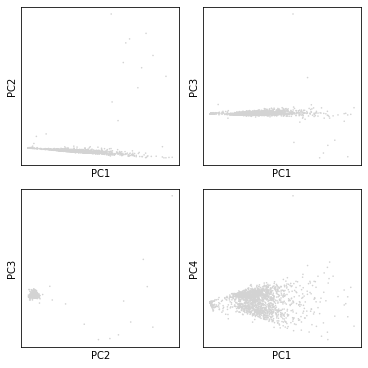

In [73]:
# show the PC plots
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], show=False, size=10)

# this looks pretty bad already

<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

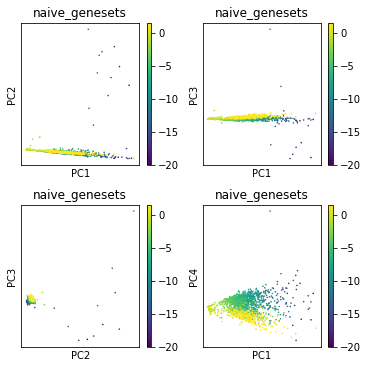

In [74]:
# next we plot and color by each geneset 
# naive 
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

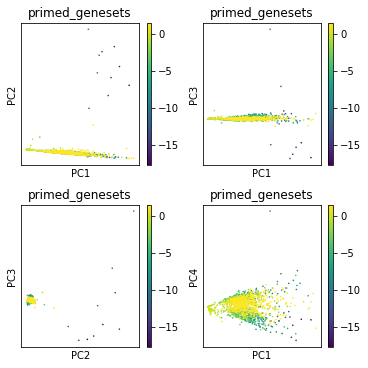

In [75]:
# primed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

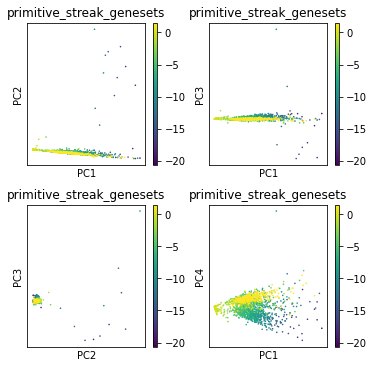

In [76]:
# primitive_streak
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

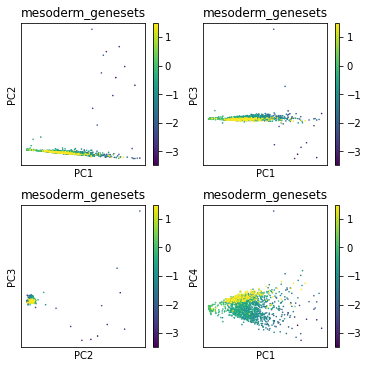

In [77]:
# mesoderm
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [78]:
# performs KNN neighbors and then leiden clustering 
# note: there are no right or wrong parmaeters to choose when clustering. Just have to pick the ones that are reasonable and give reasonable results. 
# would highly suggest playing with the parameters and see how the results differ
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [79]:
sc.tl.leiden(adata, .25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC4'>

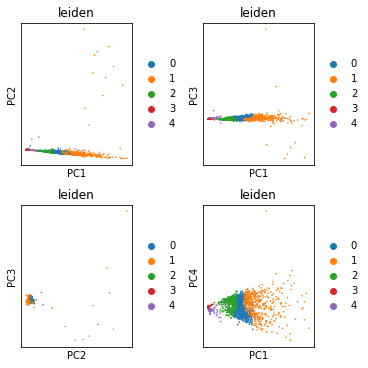

In [80]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "leiden", show=False, size=10, vmax = 1.5)

# the clusetrs here look like the correspond to the ones above but the purple one may be an outlier 
# naive is orange 1
# primed is green 2
# primitive is blue 0
# mesoderm is red 3

For this trial, leiden looks really different from geneset scores for cell type/diff type, so we will use the max geneset score to determine cell diff stage.

In [81]:
adata.obs

,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,S_score,G2M_score,phase,leiden
AAAGGATCATCAGCTA,5.900000,-8.740000,-12.240000,-1.60,2.231003,4.407257,G2M,1
AAAGTGAAGACAAGCC,-15.286667,3.166667,-9.633333,-1.75,2.099012,7.239138,G2M,1
AACACACGTGTAACGG,-0.046667,-0.053333,-0.053333,0.00,-0.000156,0.043626,G2M,4
AACCACATCCACAAGT,1.440000,-13.270000,-16.020000,-2.16,7.064634,11.007042,G2M,1
AACCATGCAGTAGATA,-0.066667,-0.053333,-0.053333,-0.01,0.043012,-0.001492,S,3
...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,-11.833333,3.046667,6.046667,-0.79,1.419227,4.775931,G2M,1
TTTCGATTCCCAAGCG,-7.820000,1.143333,-1.406667,-1.10,0.843820,5.365332,G2M,0
TTTGACTGTCACTTCC,-8.480000,-6.453333,2.146667,22.67,0.297270,6.014413,G2M,1
TTTGACTGTGCGGATA,-5.080000,3.013333,3.913333,-0.19,1.059423,2.976009,G2M,2


In [82]:
# take a subset of adata.obs and get the max geneset score of the 4 diff types for each cell and call it that cell
cell_differentiation = adata.obs[['naive_genesets', 'primed_genesets', 'primitive_streak_genesets', 'mesoderm_genesets']]
cell_differentiation['cell_type_label'] = cell_differentiation.idxmax(axis=1)

<ipython-input-82-a85028a30fd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_differentiation['cell_type_label'] = cell_differentiation.idxmax(axis=1)


In [84]:
import re
# use regex to drop the everything after the stage name
regex = r'(.*)_'
for i in range(0, len(cell_differentiation['cell_type_label'])):
    cell_differentiation['cell_type_label'][i] = re.findall(regex, cell_differentiation['cell_type_label'][i])[0] # 0 index since findall returns list

# number of each stage of differentiation
print(cell_differentiation['cell_type_label'].value_counts())

primed              618
mesoderm            498
primitive_streak    295
naive               269
Name: cell_type_label, dtype: int64


<ipython-input-84-a00fd489b9bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_differentiation['cell_type_label'][i] = re.findall(regex, cell_differentiation['cell_type_label'][i])[0] # 0 index since findall returns list
/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
# stages of differentation for each cell 
print(cell_differentiation['cell_type_label'].head())

AAAGGATCATCAGCTA       naive
AAAGTGAAGACAAGCC      primed
AACACACGTGTAACGG    mesoderm
AACCACATCCACAAGT       naive
AACCATGCAGTAGATA    mesoderm
Name: cell_type_label, dtype: object


... storing 'cell_type_label' as categorical


<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

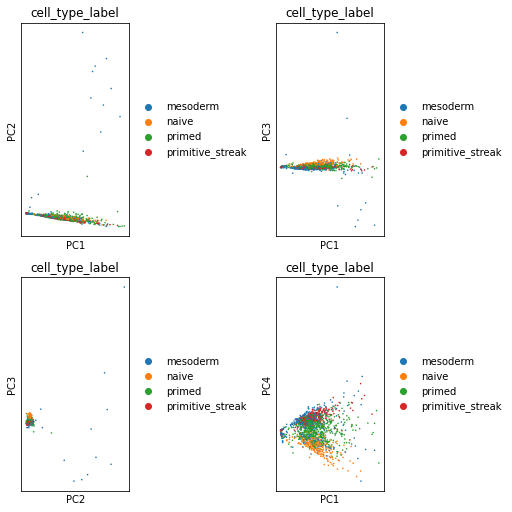

In [86]:
# add differentiation_type back to adata.obs and perform pca
adata.obs['cell_type_label'] = cell_differentiation['cell_type_label']

fig, axs = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

# this looks way worse than transformed data

In [87]:
# phase and cell stages
print('S phase and Naive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'naive')]))
print('S phase and Primed:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'primed')]))
print('S phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'primitive_streak')]))
print('S phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'mesoderm')]))
print('S phase and Other:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'other')]))

print('G2M phase and Naive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'naive')]))
print('G2M phase and Primed:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'primed')]))
print('G2M phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'primitive_streak')]))
print('G2M phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'mesoderm')]))
print('G2M phase and Other:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'other')]))

# much more g2m phase 

S phase and Naive: 34
S phase and Primed: 94
S phase and Primitive: 26
S phase and Mesoderm: 84
S phase and Other: 0
G2M phase and Naive: 234
G2M phase and Primed: 521
G2M phase and Primitive: 268
G2M phase and Mesoderm: 393
G2M phase and Other: 0


In [88]:
# Primitive    562
# Primed       403
# Naive        321
# Mesoderm     145
# Other         35

# S phase and Naive: 136
# S phase and Primed: 184
# S phase and Primitive: 238
# S phase and Mesoderm: 48
# S phase and Other: 7
# G2M phase and Naive: 159
# G2M phase and Primed: 193
# G2M phase and Primitive: 270
# G2M phase and Mesoderm: 78
# G2M phase and Other: 11

In [89]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
naive_adata = adata[adata.obs['cell_type_label'] == 'naive']
primed_adata = adata[adata.obs['cell_type_label'] == 'primed']
primitive_streak_adata = adata[adata.obs['cell_type_label'] == 'primitive_streak']
mesoderm_adata = adata[adata.obs['cell_type_label'] == 'mesoderm']

In [90]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
naive_novel_cc_genes = get_cc_genes(naive_adata, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata, cell_cycle_genes)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [91]:
# output # of novel cc genes and the genes themself for each phase for each cell type (diff type)
print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
print(naive_novel_cc_genes)
print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

Naive novel cc genes: 883 new S genes; 1916 new G2M genes
{'S': ['Ddx1', 'Rps8', 'Psmb2', 'Nipsnap1', 'Mrpl42', 'Emb', 'Rps7', 'Prdx1', 'Ubl5', 'Snrpd1', 'Paics', 'Pin1', 'Mak16', 'Twf2', 'Rpl28', 'Cct4', 'Psmd6', 'Ccne1', 'Fbl', 'Hspd1', 'Arpp19', 'Rbmxl1', 'Lin28a', 'Pfdn1', 'Lig1', 'Rpl18', 'Hsd17b10', 'Cdk4', 'Mrpl51', 'Dynll1', 'Tuba4a', 'Naa15', 'Ddx24', 'Dnaja2', 'Hnrnpd', 'Eef1g', 'Selenof', 'Rpl8', 'Smarcc1', 'Ncor1', 'Trap1a', 'Rps21', 'Uqcrq', '2410015M20Rik', 'Mettl9', 'Cops5', 'Arf1', 'Med28', 'Cib1', 'Cox6b1', 'Ddx5', 'Kpnb1', 'Dut', 'Krtcap2', 'Pdcd6', 'Bax', 'Dctpp1', 'Timm17a', 'Mrps10', 'Eif1', 'Pabpc1', 'Bex3', 'Ube2k', 'Ywhah', 'Rheb', 'Psmb1', 'Akr1a1', 'Glrx3', 'Rps14', 'Rpl21', 'Uqcrb', 'Nop14', 'Gdi2', 'Fdps', 'Uchl3', 'Fam92a', 'Txndc17', 'Psmc5', 'Rps15a', 'Aimp1', 'Mrpl55', 'Rps27', 'Lman2', 'Rps25', 'Banf1', 'G3bp2', 'Abce1', 'Smarca4', 'Hnrnpa3', 'Npm1', 'Baz1b', 'Suds3', 'Rpn2', 'Serbp1', 'Hsp90b1', 'Edf1', 'Ubap2l', 'Ywhab', 'Eef1d', 'Lsm4', 'Ddx47', 'Eif

In [92]:
# no cleaning steps identified way too many cell cycle corr'd genes

In [93]:
# reload our data without MEF's or cleaning
adata = sc.read_h5ad('unprocessed_data_no_mefs_pt6.h5ad')

In [94]:
# lets see what happens if someone excludes too many doublets because they thought more cells were inputted in the 10x run

In [95]:
adata = preprocess_pipeline(adata, exclude_high_ribo = True, ribo_thresh = 35, exclude_high_mt = True, mt_thresh = 3, exclude_doublets = True, 
                            doublet_thresh = 90, exclude_sporad_genes = True, 
                            exclude_bad_genes = True, normalize = True, logT= True, hvg = True, scale = True, comp_pca = True)

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


... storing 'phase' as categorical


<AxesSubplot:xlabel='PC1', ylabel='PC4'>

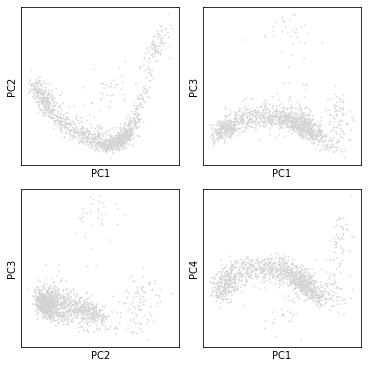

In [96]:
# show the PC plots
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], show=False, size=10)

# this looks pretty bad already

<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

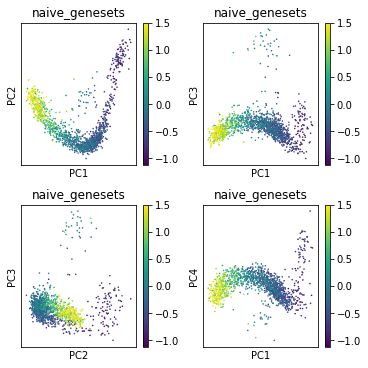

In [97]:
# next we plot and color by each geneset 
# naive 
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

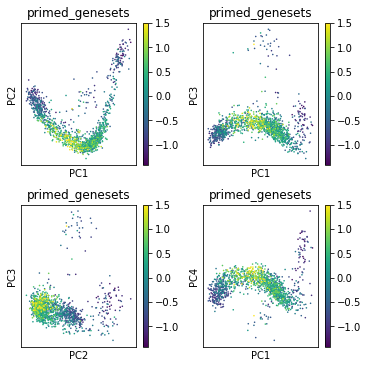

In [98]:
# primed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

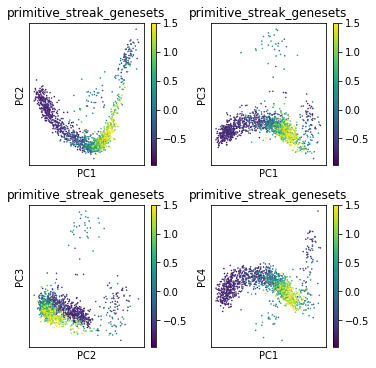

In [99]:
# primitive_streak
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

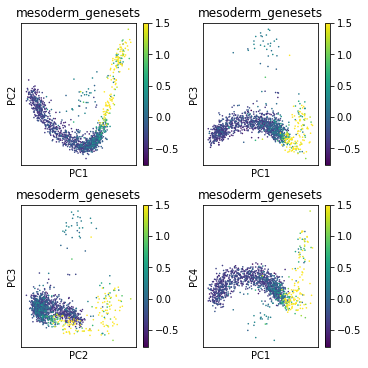

In [100]:
# mesoderm
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [101]:
# performs KNN neighbors and then leiden clustering 
# note: there are no right or wrong parmaeters to choose when clustering. Just have to pick the ones that are reasonable and give reasonable results. 
# would highly suggest playing with the parameters and see how the results differ
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [102]:
sc.tl.leiden(adata, .25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC4'>

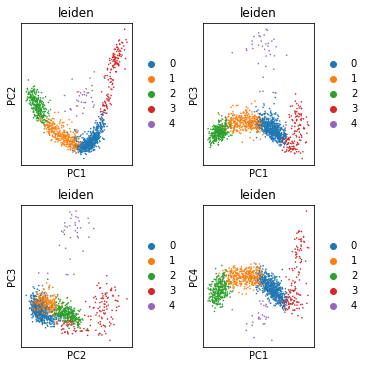

In [103]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "leiden", show=False, size=10, vmax = 1.5)

# the clusetrs here look like the correspond to the ones above but the purple one may be an outlier 
# naive is green 2
# primed is orange 1
# primitive is blue 0
# mesoderm is red 3

# we can still id the cell stages here 

In [104]:
# making a new column in adata.obs dataframe and the assigning cell types
adata.obs['cell_type_label'] = None 
adata.obs.loc[adata.obs['leiden'] == '0', 'cell_type_label'] = 'Primitive'
adata.obs.loc[adata.obs['leiden'] == '1', 'cell_type_label'] = 'Primed'
adata.obs.loc[adata.obs['leiden'] == '2', 'cell_type_label'] = 'Naive'
adata.obs.loc[adata.obs['leiden'] == '3', 'cell_type_label'] = 'Mesoderm'
adata.obs.loc[adata.obs['leiden'] == '4', 'cell_type_label'] = 'Other'

... storing 'cell_type_label' as categorical


<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

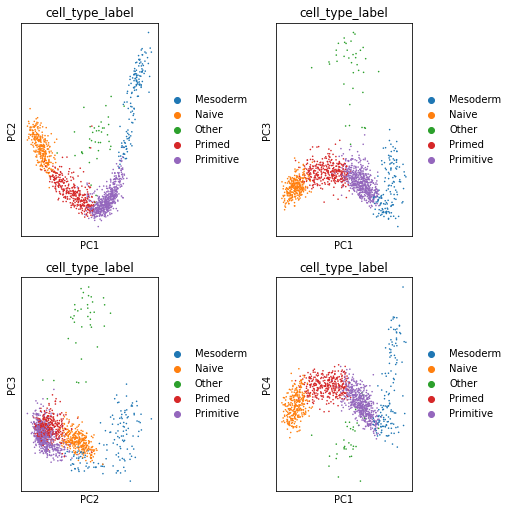

In [105]:
# replot with cell type classifiers, should be identical to previous plot but colors moved around
fig, axs = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [106]:
# get counts of each cell type
adata.obs['cell_type_label'].value_counts()

Primitive    548
Primed       336
Naive        295
Mesoderm     142
Other         38
Name: cell_type_label, dtype: int64

In [107]:
# phase and cell stages
print('S phase and Naive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Naive')]))
print('S phase and Primed:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primed')]))
print('S phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('S phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('S phase and Other:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Other')]))

print('G2M phase and Naive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Naive')]))
print('G2M phase and Primed:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primed')]))
print('G2M phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('G2M phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('G2M phase and Other:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Other')]))

# these numbers are pretty similar to the orginial but there are some fluctuations, just lose cells in each cat

S phase and Naive: 130
S phase and Primed: 151
S phase and Primitive: 218
S phase and Mesoderm: 40
S phase and Other: 7
G2M phase and Naive: 134
G2M phase and Primed: 153
G2M phase and Primitive: 241
G2M phase and Mesoderm: 70
G2M phase and Other: 10


In [108]:
# Primitive    562
# Primed       403
# Naive        321
# Mesoderm     145
# Other         35

# S phase and Naive: 136
# S phase and Primed: 184
# S phase and Primitive: 238
# S phase and Mesoderm: 48
# S phase and Other: 7
# G2M phase and Naive: 159
# G2M phase and Primed: 193
# G2M phase and Primitive: 270
# G2M phase and Mesoderm: 78
# G2M phase and Other: 11

In [109]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
naive_adata = adata[adata.obs['cell_type_label'] == 'Naive']
primed_adata = adata[adata.obs['cell_type_label'] == 'Primed']
primitive_streak_adata = adata[adata.obs['cell_type_label'] == 'Primitive']
mesoderm_adata = adata[adata.obs['cell_type_label'] == 'Mesoderm']

In [110]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
naive_novel_cc_genes = get_cc_genes(naive_adata, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata, cell_cycle_genes)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [112]:
# outpur # of novel cc genes and the genes themself for each phase for each cell type (diff type)
print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
print(naive_novel_cc_genes)
print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

# 2 more naive g2m
# 5 less primed g2m
# 1 new prim g2m
# 1 new s meso

Naive novel cc genes: 0 new S genes; 10 new G2M genes
{'S': [], 'G2M': ['Jpt1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Fzr1', 'Ccnf', 'H2afx', 'Tuba1c']}

Primed novel cc genes: 1 new S genes; 8 new G2M genes
{'S': ['Orc6'], 'G2M': ['Ccna2', 'Jpt1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Tuba1c']}

Primitive streak novel cc genes: 1 new S genes; 22 new G2M genes
{'S': ['Ccne1'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Arl6ip1', 'Fzr1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Sgo2a', 'Jpt1', 'Mis18bp1', 'Plk1', 'Fam83d']}

Mesoderm novel cc genes: 6 new S genes; 24 new G2M genes
{'S': ['Mcm3', 'Chaf1a', 'Dhfr', 'Lig1', 'Orc6', 'Dut'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Fzr1', 'Nde1', 'Arl6ip1', 'Kif22', 'Ccnf', 'Kpna2', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Arhgap19', 'Sgo2a', 'Mis18bp1', 'Plk1', 'Fam83d']}


In [113]:
# what happens if we dont exclude high ribo
adata = sc.read_h5ad('unprocessed_data_no_mefs_pt6.h5ad')

In [114]:
adata = preprocess_pipeline(adata, exclude_high_ribo = False, ribo_thresh = 35, exclude_high_mt = True, mt_thresh = 3, exclude_doublets = True, 
                            doublet_thresh = 98, exclude_sporad_genes = True, 
                            exclude_bad_genes = True, normalize = True, logT= True, hvg = True, scale = True, comp_pca = True)

Trying to set attribute `.var` of view, copying.


... storing 'phase' as categorical


<AxesSubplot:xlabel='PC1', ylabel='PC4'>

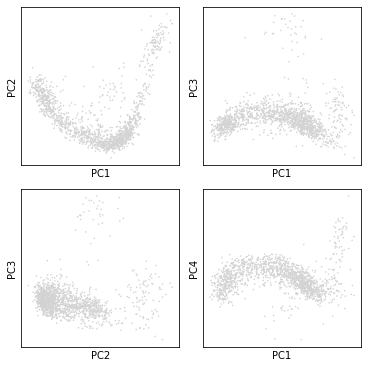

In [115]:
# show the PC plots
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], show=False, size=10)

# this looks pretty bad already

<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

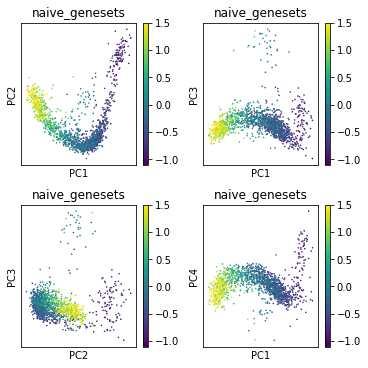

In [116]:
# next we plot and color by each geneset 
# naive 
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

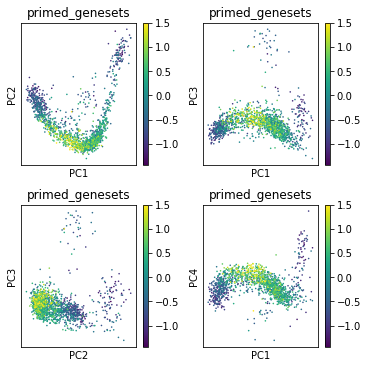

In [117]:
# primed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

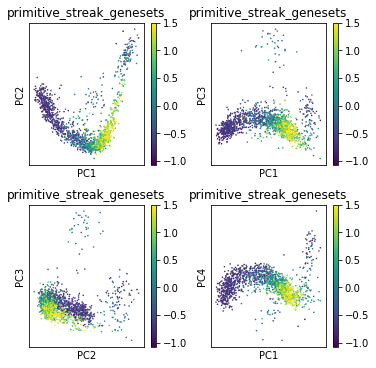

In [118]:
# primitive_streak
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

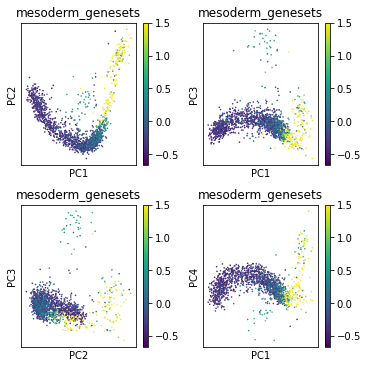

In [119]:
# mesoderm
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [120]:
# performs KNN neighbors and then leiden clustering 
# note: there are no right or wrong parmaeters to choose when clustering. Just have to pick the ones that are reasonable and give reasonable results. 
# would highly suggest playing with the parameters and see how the results differ
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [121]:
sc.tl.leiden(adata, .25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC4'>

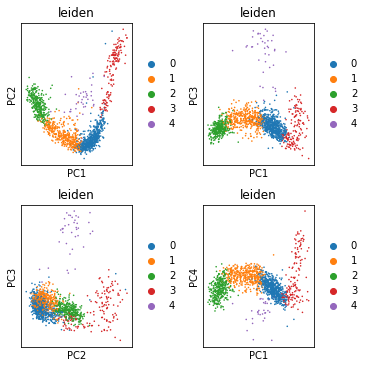

In [122]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "leiden", show=False, size=10, vmax = 1.5)

# the clusetrs here look like the correspond to the ones above but the purple one may be an outlier 
# naive is green 2
# primed is primed 1
# primitive is blue 0
# mesoderm is red 3

# clustering here looks pretty good, similar to the "standard run" 

In [123]:
# making a new column in adata.obs dataframe and the assigning cell types
adata.obs['cell_type_label'] = None 
adata.obs.loc[adata.obs['leiden'] == '0', 'cell_type_label'] = 'Primitive'
adata.obs.loc[adata.obs['leiden'] == '2', 'cell_type_label'] = 'Naive'
adata.obs.loc[adata.obs['leiden'] == '1', 'cell_type_label'] = 'Primed'
adata.obs.loc[adata.obs['leiden'] == '3', 'cell_type_label'] = 'Mesoderm'
adata.obs.loc[adata.obs['leiden'] == '4', 'cell_type_label'] = 'Other'

... storing 'cell_type_label' as categorical


<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

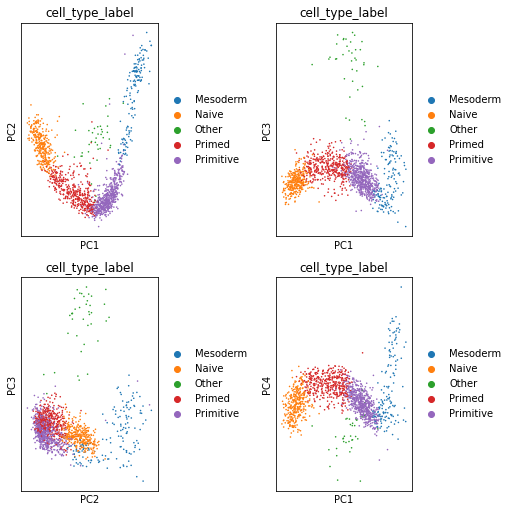

In [124]:
# replot with cell type classifiers, should be identical to previous plot but colors moved around
fig, axs = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [125]:
# get counts of each cell type
adata.obs['cell_type_label'].value_counts()

Primitive    571
Primed       403
Naive        322
Mesoderm     146
Other         39
Name: cell_type_label, dtype: int64

In [126]:
# phase and cell stages
print('S phase and Naive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Naive')]))
print('S phase and Primed:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primed')]))
print('S phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('S phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('S phase and Other:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Other')]))

print('G2M phase and Naive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Naive')]))
print('G2M phase and Primed:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primed')]))
print('G2M phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('G2M phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('G2M phase and Other:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Other')]))

# slight differences here from orig

S phase and Naive: 148
S phase and Primed: 182
S phase and Primitive: 216
S phase and Mesoderm: 45
S phase and Other: 9
G2M phase and Naive: 143
G2M phase and Primed: 181
G2M phase and Primitive: 257
G2M phase and Mesoderm: 67
G2M phase and Other: 11


In [127]:
# original q4 output
# Primitive    562
# Primed       403
# Naive        321
# Mesoderm     145
# Other         35

# S phase and Naive: 136
# S phase and Primed: 184
# S phase and Primitive: 238
# S phase and Mesoderm: 48
# S phase and Other: 7
# G2M phase and Naive: 159
# G2M phase and Primed: 193
# G2M phase and Primitive: 270
# G2M phase and Mesoderm: 78
# G2M phase and Other: 11

In [128]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
naive_adata = adata[adata.obs['cell_type_label'] == 'Naive']
primed_adata = adata[adata.obs['cell_type_label'] == 'Primed']
primitive_streak_adata = adata[adata.obs['cell_type_label'] == 'Primitive']
mesoderm_adata = adata[adata.obs['cell_type_label'] == 'Mesoderm']

In [129]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
naive_novel_cc_genes = get_cc_genes(naive_adata, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata, cell_cycle_genes)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [130]:
# output # of novel cc genes and the genes themself for each phase for each cell type (diff type)
print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
print(naive_novel_cc_genes)
print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

# 3 new for g2m naive
# primed same
# 1 new prim g2m
# 1 new s medo orc6

Naive novel cc genes: 0 new S genes; 11 new G2M genes
{'S': [], 'G2M': ['Jpt1', 'Mis18bp1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Fzr1', 'Ccnf', 'H2afx', 'Tuba1c']}

Primed novel cc genes: 1 new S genes; 13 new G2M genes
{'S': ['Orc6'], 'G2M': ['Ccna2', 'Jpt1', 'Mis18bp1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Fzr1', 'Ccnf', 'Fam83d', 'H2afx', 'Tuba1c']}

Primitive streak novel cc genes: 1 new S genes; 22 new G2M genes
{'S': ['Ccne1'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Arl6ip1', 'Fzr1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Sgo2a', 'Jpt1', 'Mis18bp1', 'Plk1', 'Fam83d']}

Mesoderm novel cc genes: 6 new S genes; 24 new G2M genes
{'S': ['Mcm3', 'Chaf1a', 'Dhfr', 'Lig1', 'Orc6', 'Dut'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Fzr1', 'Nde1', 'Arl6ip1', 'Kif22', 'Ccnf', 'Kpna2', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Arhgap19', 'Sgo2a', 'Mis18bp1', 'Pl

In [131]:
# what happens if we dont exclude high mt
adata = sc.read_h5ad('unprocessed_data_no_mefs_pt6.h5ad')

In [132]:
adata = preprocess_pipeline(adata, exclude_high_ribo = True, ribo_thresh = 35, exclude_high_mt = False, mt_thresh = 3, exclude_doublets = True, 
                            doublet_thresh = 98, exclude_sporad_genes = True, 
                            exclude_bad_genes = True, normalize = True, logT= True, hvg = True, scale = True, comp_pca = True)

Trying to set attribute `.var` of view, copying.


... storing 'phase' as categorical


<AxesSubplot:xlabel='PC1', ylabel='PC4'>

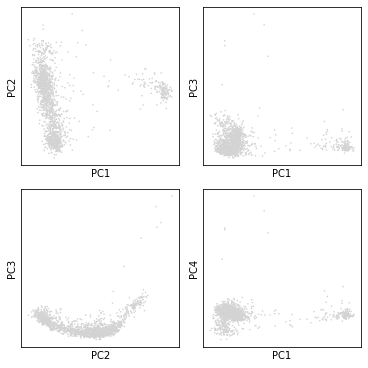

In [133]:
# show the PC plots
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], show=False, size=10)

# this looks pretty bad already

<AxesSubplot:title={'center':'naive_genesets'}, xlabel='PC1', ylabel='PC4'>

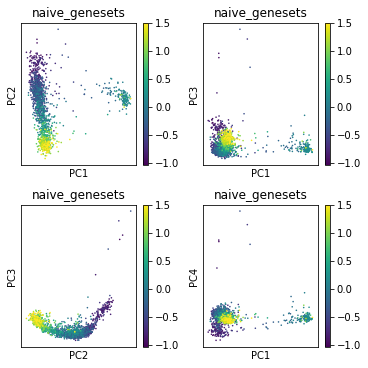

In [134]:
# next we plot and color by each geneset 
# naive 
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "naive_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "naive_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primed_genesets'}, xlabel='PC1', ylabel='PC4'>

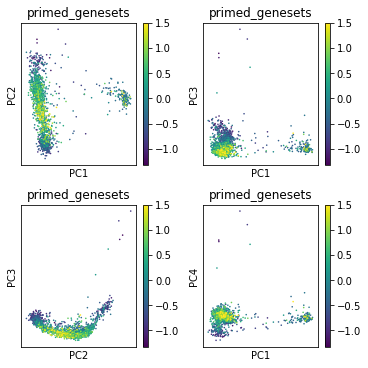

In [135]:
# primed
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primed_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primed_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'primitive_streak_genesets'}, xlabel='PC1', ylabel='PC4'>

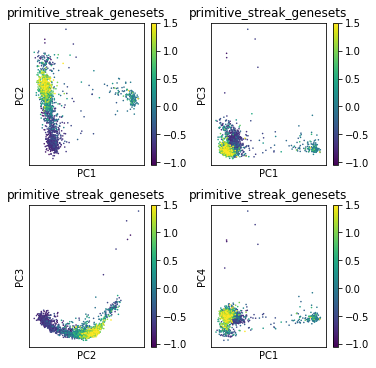

In [136]:
# primitive_streak
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "primitive_streak_genesets", show=False, size=10, vmax = 1.5)

<AxesSubplot:title={'center':'mesoderm_genesets'}, xlabel='PC1', ylabel='PC4'>

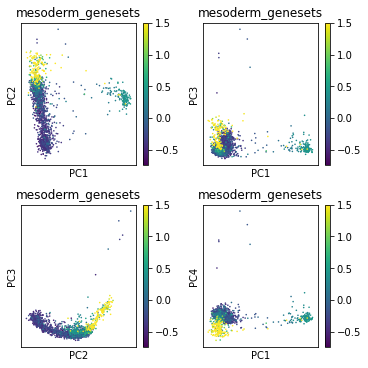

In [137]:
# mesoderm
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "mesoderm_genesets", show=False, size=10, vmax = 1.5)

In [138]:
# performs KNN neighbors and then leiden clustering 
# note: there are no right or wrong parmaeters to choose when clustering. Just have to pick the ones that are reasonable and give reasonable results. 
# would highly suggest playing with the parameters and see how the results differ
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [139]:
sc.tl.leiden(adata, .25)

<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC4'>

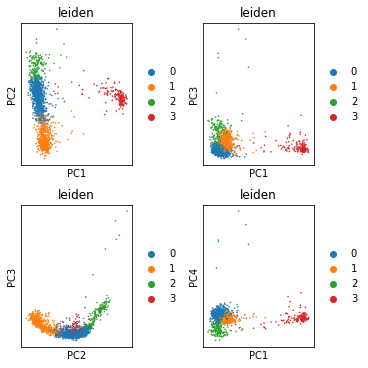

In [140]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "leiden", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "leiden", show=False, size=10, vmax = 1.5)

# the clusetrs here look like the correspond to the ones above but the purple one may be an outlier 
# primed is orange 1
# primitive is blue 0
# mesoderm is green 2
# other is red 3

# clustering here looks pretty different. Looks like high mt skews our cluestering results pretty heavily, red other could be high mt cells?
# not excluding high mt is worse than not excluding high ribo
# no seperation between naive and primed here, so we will have to exclude naive from further analysis

In [141]:
# making a new column in adata.obs dataframe and the assigning cell types
adata.obs['cell_type_label'] = None 
adata.obs.loc[adata.obs['leiden'] == '0', 'cell_type_label'] = 'Primitive'
adata.obs.loc[adata.obs['leiden'] == '2', 'cell_type_label'] = 'Mesoderm'
adata.obs.loc[adata.obs['leiden'] == '1', 'cell_type_label'] = 'Primed'
adata.obs.loc[adata.obs['leiden'] == '3', 'cell_type_label'] = 'Other'

... storing 'cell_type_label' as categorical


<AxesSubplot:title={'center':'cell_type_label'}, xlabel='PC1', ylabel='PC4'>

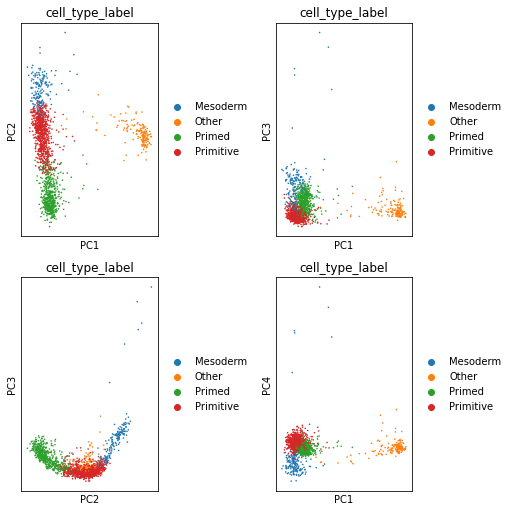

In [142]:
# replot with cell type classifiers, should be identical to previous plot but colors moved around
fig, axs = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], color = "cell_type_label", show=False, size=10, vmax = 1.5)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], color = "cell_type_label", show=False, size=10, vmax = 1.5)

In [143]:
# get counts of each cell type
adata.obs['cell_type_label'].value_counts()

Primitive    783
Primed       535
Mesoderm     167
Other        159
Name: cell_type_label, dtype: int64

In [144]:
# phase and cell stages
print('S phase and Naive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Naive')]))
print('S phase and Primed:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primed')]))
print('S phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('S phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('S phase and Other:',len(adata.obs[(adata.obs['phase'] =='S') & (adata.obs['cell_type_label'] == 'Other')]))

print('G2M phase and Naive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Naive')]))
print('G2M phase and Primed:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primed')]))
print('G2M phase and Primitive:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Primitive')]))
print('G2M phase and Mesoderm:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Mesoderm')]))
print('G2M phase and Other:',len(adata.obs[(adata.obs['phase'] =='G2M') & (adata.obs['cell_type_label'] == 'Other')]))

# number pretty diff here since we dont have naive cells 
# this is prob the second worst with no cleaning being the worst

S phase and Naive: 0
S phase and Primed: 247
S phase and Primitive: 328
S phase and Mesoderm: 53
S phase and Other: 10
G2M phase and Naive: 0
G2M phase and Primed: 241
G2M phase and Primitive: 365
G2M phase and Mesoderm: 75
G2M phase and Other: 12


In [145]:
# original q4 output
# Primitive    562
# Primed       403
# Naive        321
# Mesoderm     145
# Other         35

# S phase and Naive: 136
# S phase and Primed: 184
# S phase and Primitive: 238
# S phase and Mesoderm: 48
# S phase and Other: 7
# G2M phase and Naive: 159
# G2M phase and Primed: 193
# G2M phase and Primitive: 270
# G2M phase and Mesoderm: 78
# G2M phase and Other: 11

In [146]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
other_adata = adata[adata.obs['cell_type_label'] == 'Naive']
primed_adata = adata[adata.obs['cell_type_label'] == 'Primed']
primitive_streak_adata = adata[adata.obs['cell_type_label'] == 'Primitive']
mesoderm_adata = adata[adata.obs['cell_type_label'] == 'Mesoderm']

In [148]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
# exclude naive cuz we dont have any
# naive_novel_cc_genes = get_cc_genes(naive_adata, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata, cell_cycle_genes)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [150]:
# output # of novel cc genes and the genes themself for each phase for each cell type (diff type)
# print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
# print(naive_novel_cc_genes)
# print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

# no naive so thats a big diff
# primed is the same same as og naive, so primed and naive might be mixed together here
# prim the same as og
# meso has multiple new genes for both phases

Primed novel cc genes: 0 new S genes; 8 new G2M genes
{'S': [], 'G2M': ['Jpt1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Ccnf', 'Tuba1c']}

Primitive streak novel cc genes: 1 new S genes; 21 new G2M genes
{'S': ['Ccne1'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Arl6ip1', 'Fzr1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Sgo2a', 'Jpt1', 'Mis18bp1', 'Plk1', 'Fam83d']}

Mesoderm novel cc genes: 19 new S genes; 29 new G2M genes
{'S': ['Dhfr', 'Anp32b', 'Snrpd1', 'Paics', 'Mcm7', 'Ptma', 'Ranbp1', 'Eif5a', 'Chaf1a', 'Lig1', 'Ptges3', 'Smc3', 'Rbbp4', 'Mcm3', 'Srsf7', 'Prelid3b', 'Pclaf', 'Nxt1', 'Dut'], 'G2M': ['Racgap1', 'Lsm2', 'Kif20a', 'Smc2', 'Fzr1', 'Nde1', 'Arl6ip1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Nt5dc2', 'Incenp', 'Prc1', 'Sapcd2', 'Ncapg', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Arhgap19', 'Sgo2a', 'Mis18bp1', 'Plk1', 'Tuba1b', 'Fam83d', 'Lsm3', 'Snrpb']}


In [151]:
# not doing any preprocessing def makes the biggest difference in out results. 
# excluding too many doublets leads too many lost 'good' cells
# not excluding high mt is much worse than not excluding high ribo

### Bonus mission: 

Write a function that will generate a heatmap of your novel CC genes and that orders and displays cells by predicted phase of CC.

In [152]:
###  Bonus mission code, figures and explanatory text goes here and in subsequent cells. Show all code.
# heres our good adata
adata2_refined.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets,leiden,cell_type_label,S_score,G2M_score,phase
AAAGGATCATCAGCTA,6108,51696.0,11336.0,21.928196,1206.0,2.332869,1.462597,-0.845355,-0.765111,-0.494201,-0.234230,2,Naive,0.121245,-0.180180,S
AAGTTCGTCATCCTAT,6161,50670.0,10793.0,21.300571,648.0,1.278863,1.152509,-0.663506,-0.674499,-0.529671,-0.144185,2,Naive,0.153964,0.117394,S
AATCACGTCGACGACC,5920,51203.0,13795.0,26.941782,506.0,0.988223,1.180865,-0.918670,-0.720854,-0.226108,-0.167448,2,Naive,-0.406983,0.231144,G2M
ACAAGCTAGTGTTCAC,6578,54268.0,13539.0,24.948404,979.0,1.804010,2.070385,-0.566424,-0.680331,-0.382433,-0.201345,2,Naive,-0.123072,0.221507,G2M
ACATTTCCACCCAATA,494,669.0,138.0,20.627802,0.0,0.000000,-0.110276,-0.376076,-0.016581,0.353827,-0.058090,4,Other,-0.146778,-0.585443,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCGAACA,6226,47202.0,11664.0,24.710817,746.0,1.580442,-0.553922,-0.035149,0.853431,-0.111625,-0.286409,0,Primitive,-0.078648,-0.012066,G1
TTTCGATTCCCAAGCG,5435,30923.0,7146.0,23.109013,398.0,1.287068,-0.832274,0.272020,0.785349,-0.468100,-0.022966,0,Primitive,-0.211332,0.406195,G2M
TTTGACTGTCACTTCC,5767,35729.0,7860.0,21.998936,538.0,1.505780,-0.604116,-0.717059,0.734134,4.251657,-0.161055,3,Mesoderm,-0.284396,0.486331,G2M
TTTGACTGTGCGGATA,4937,23234.0,5097.0,21.937677,326.0,1.403116,-0.396972,0.327058,1.400823,-0.116942,-0.196782,0,Primitive,0.003583,-0.001892,S


In [153]:
# now let's run on function on each cell type (stage of differentiation)
# first subset each diff type
naive_adata = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Naive']
primed_adata = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Primed']
primitive_streak_adata = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Primitive']
mesoderm_adata = adata2_refined[adata2_refined.obs['cell_type_label'] == 'Mesoderm']

In [154]:
# run our function on each diff type subset
# default pthresh = 0.45 and novel = True
naive_novel_cc_genes = get_cc_genes(naive_adata, cell_cycle_genes) 
primed_novel_cc_genes = get_cc_genes(primed_adata, cell_cycle_genes)
primitive_streak_novel_cc_genes = get_cc_genes(primitive_streak_adata, cell_cycle_genes)
mesoderm_novel_cc_genes = get_cc_genes(mesoderm_adata, cell_cycle_genes)

/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [155]:
# output # of novel cc genes and the genes themself for each phase for each cell type (diff type)
print('Naive novel cc genes:', len(naive_novel_cc_genes['S']), 'new S genes;', len(naive_novel_cc_genes['G2M']), 'new G2M genes')
print(naive_novel_cc_genes)
print('')

print('Primed novel cc genes:', len(primed_novel_cc_genes['S']), 'new S genes;', len(primed_novel_cc_genes['G2M']), 'new G2M genes')
print(primed_novel_cc_genes)
print('')

print('Primitive streak novel cc genes:', len(primitive_streak_novel_cc_genes['S']), 'new S genes;', 
      len(primitive_streak_novel_cc_genes['G2M']), 'new G2M genes')
print(primitive_streak_novel_cc_genes)
print('')

print('Mesoderm novel cc genes:', len(mesoderm_novel_cc_genes['S']), 'new S genes;', len(mesoderm_novel_cc_genes['G2M']), 'new G2M genes')
print(mesoderm_novel_cc_genes) 

# mis18bp1 is new for g2m naive but h2afx is missing
# primed g2m new: kif20a, ccna2, sgo2a
# prim the same
# mesoderm has many new genes for both phases

Naive novel cc genes: 0 new S genes; 8 new G2M genes
{'S': [], 'G2M': ['Jpt1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Ccnf', 'Tuba1c']}

Primed novel cc genes: 1 new S genes; 13 new G2M genes
{'S': ['Orc6'], 'G2M': ['Ccna2', 'Jpt1', 'Mis18bp1', 'Incenp', 'Plk1', 'Prc1', 'Bub3', 'Arl6ip1', 'Fzr1', 'Ccnf', 'Fam83d', 'H2afx', 'Tuba1c']}

Primitive streak novel cc genes: 1 new S genes; 21 new G2M genes
{'S': ['Ccne1'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Arl6ip1', 'Fzr1', 'Kif22', 'Ccnf', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Sgo2a', 'Jpt1', 'Mis18bp1', 'Plk1', 'Fam83d']}

Mesoderm novel cc genes: 5 new S genes; 24 new G2M genes
{'S': ['Mcm3', 'Chaf1a', 'Dhfr', 'Lig1', 'Dut'], 'G2M': ['Racgap1', 'Kif20a', 'Smc2', 'Fzr1', 'Nde1', 'Arl6ip1', 'Kif22', 'Ccnf', 'Kpna2', 'Dbf4', 'Tuba1c', 'Incenp', 'Prc1', 'Sapcd2', 'H2afx', 'Ccna2', 'Bub1b', 'Bub3', 'Pimreg', 'Arhgap19', 'Sgo2a', 'Mis18bp1', 'Plk1', 'Fam83d']}


In [156]:
set([1,2,3,3,4]+[1,5,7,4,10])

{1, 2, 3, 4, 5, 7, 10}

In [157]:
# get all the unique novel cc genes cuz these are what we want to use for our heatmap, we can sum and use a set for this
all_unique_novel_cc_genes = set(naive_novel_cc_genes['S'] + naive_novel_cc_genes['G2M'] + primed_novel_cc_genes['S'] +primed_novel_cc_genes['G2M'] + 
                                primitive_streak_novel_cc_genes['S'] + primitive_streak_novel_cc_genes['G2M'] + 
                                mesoderm_novel_cc_genes['S'] + mesoderm_novel_cc_genes['G2M'])
all_unique_novel_cc_genes

{'Arhgap19',
 'Arl6ip1',
 'Bub1b',
 'Bub3',
 'Ccna2',
 'Ccne1',
 'Ccnf',
 'Chaf1a',
 'Dbf4',
 'Dhfr',
 'Dut',
 'Fam83d',
 'Fzr1',
 'H2afx',
 'Incenp',
 'Jpt1',
 'Kif20a',
 'Kif22',
 'Kpna2',
 'Lig1',
 'Mcm3',
 'Mis18bp1',
 'Nde1',
 'Orc6',
 'Pimreg',
 'Plk1',
 'Prc1',
 'Racgap1',
 'Sapcd2',
 'Sgo2a',
 'Smc2',
 'Tuba1c'}

In [158]:
adata2_refined.obs.sort_values('phase')

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,naive_genesets,primed_genesets,primitive_streak_genesets,mesoderm_genesets,mef_genesets,leiden,cell_type_label,S_score,G2M_score,phase
AGTCATGTCCTTACCG,4782,21324.0,4901.0,22.983494,397.0,1.861752,-0.032396,0.820778,1.074630,0.409661,-0.187428,0,Primitive,-0.169954,-0.088506,G1
CACTGGGTCTCCCAAT,507,672.0,141.0,20.982143,8.0,1.190476,-0.074815,-0.436716,-0.234773,0.097695,-0.007134,4,Other,-0.345997,-0.287390,G1
GGGCTCACAGACTGCC,3739,15747.0,4717.0,29.954914,313.0,1.987680,-0.177459,-0.100961,0.836455,-0.152566,-0.107768,0,Primitive,-0.558101,-0.790026,G1
GGGCTACTCCATTGGA,4658,24148.0,5694.0,23.579594,407.0,1.685440,1.172359,-0.886349,-0.658662,-0.464932,-0.283386,2,Naive,-0.336283,-0.022090,G1
GGGCTACTCACTTATC,4903,22268.0,4510.0,20.253279,339.0,1.522364,-0.738347,0.029623,1.035044,0.235327,-0.316925,0,Primitive,-0.255715,-0.632524,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGCAGGTCCCAAGCG,4947,27912.0,6187.0,22.166092,361.0,1.293351,-0.757755,-0.055371,1.897916,0.352576,-0.207423,0,Primitive,0.442471,-0.110176,S
CTGCATCTCGAGCACC,6158,41973.0,11106.0,26.459867,611.0,1.455698,0.213572,1.007073,-0.712232,-0.109063,-0.095686,0,Primitive,0.404621,-0.161070,S
CTGCCATAGCTGACCC,5350,31833.0,7617.0,23.927998,335.0,1.052367,-0.511868,-0.093552,1.632817,0.001976,-0.106823,0,Primitive,0.300656,0.005791,S
CTGCTCACATGAAGCG,3146,14600.0,4414.0,30.232876,326.0,2.232877,-0.189631,0.376734,0.596491,0.444766,-0.083775,0,Primitive,0.170024,-0.298956,S


In [159]:
adata2_refined_x_df = adata2_refined.to_df() # covert to df

In [160]:
adata2_refined_x_df['phase'] = adata2_refined.obs['phase'] # add the phase column so we can sort the df by phase
adata2_refined_x_df_sorted = adata2_refined_x_df.sort_values('phase') # sort the df by phase

In [161]:
adata2_refined_x_df_sorted

,Xkr4,Sox17,Mrpl15,Rgs20,Npbwr1,4732440D04Rik,Gm26901,Sntg1,Mybl1,Vcpip1,...,Mid1,Gm21887,Zfy1,Uty,Ddx3y,Uba1y,Eif2s3y,Gm29650,Gm47283,phase
AGTCATGTCCTTACCG,-0.156202,-0.144076,0.949543,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,-0.658976,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,1.646011,-0.081604,0.413644,G1
CACTGGGTCTCCCAAT,-0.156202,-0.144076,-1.163925,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,-0.658976,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,-0.978563,-0.081604,-2.233459,G1
GGGCTCACAGACTGCC,-0.156202,-0.144076,0.559243,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,2.609551,-0.658976,...,-0.259857,7.478729,-0.056427,-0.383803,-0.611755,-0.080264,-0.978563,-0.081604,-0.998551,G1
GGGCTACTCCATTGGA,-0.156202,-0.144076,-0.011565,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,1.067121,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,-0.978563,-0.081604,-0.046508,G1
GGGCTACTCACTTATC,-0.156202,-0.144076,1.451487,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,-0.658976,...,-0.259857,-0.216697,-0.056427,2.506490,-0.611755,-0.080264,-0.978563,-0.081604,-0.802186,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGCAGGTCCCAAGCG,-0.156202,-0.144076,-1.163925,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,-0.658976,...,-0.259857,-0.216697,-0.056427,2.062944,-0.611755,-0.080264,0.979618,-0.081604,1.016900,S
CTGCATCTCGAGCACC,-0.156202,-0.144076,-1.163925,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,1.899123,-0.658976,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,-0.978563,-0.081604,0.767596,S
CTGCCATAGCTGACCC,-0.156202,-0.144076,0.960363,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,0.709133,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,-0.329572,-0.081604,-0.711088,S
CTGCTCACATGAAGCG,-0.156202,-0.144076,0.662583,-0.117874,-0.057938,-0.105507,-0.156794,-0.049548,-0.483387,-0.658976,...,-0.259857,-0.216697,-0.056427,-0.383803,-0.611755,-0.080264,-0.978563,-0.081604,-0.162216,S


In [162]:
# subset just the unique novel cc genes
data_hmap = adata2_refined_x_df_sorted[np.intersect1d(adata2_refined_x_df_sorted.columns, list(all_unique_novel_cc_genes))] 

In [163]:
data_hmap

,Arhgap19,Arl6ip1,Bub1b,Bub3,Ccna2,Ccne1,Ccnf,Chaf1a,Dbf4,Dhfr,...,Nde1,Orc6,Pimreg,Plk1,Prc1,Racgap1,Sapcd2,Sgo2a,Smc2,Tuba1c
AGTCATGTCCTTACCG,0.797738,0.556211,0.235025,0.672556,0.297230,-0.085525,0.157262,1.172690,0.251656,1.510753,...,-1.209913,1.579884,0.243657,-0.542861,-1.135931,0.834583,0.572187,-0.086691,-0.341765,0.376314
CACTGGGTCTCCCAAT,-0.771889,-2.698093,-1.475651,-2.386335,-2.330642,-1.910629,-1.450460,-1.588002,-2.087965,-2.082458,...,-1.209913,-2.223166,-0.968530,3.865805,-1.135931,-1.461866,-0.859547,-1.166515,-2.620221,-1.890287
GGGCTCACAGACTGCC,-0.771889,-1.092912,-0.080891,0.447076,-2.330642,-0.947494,-1.450460,-0.131143,-0.853312,-0.756808,...,-1.209913,-0.100005,-0.968530,-1.392149,-1.135931,-1.461866,-0.859547,-1.166515,-1.417845,-1.890287
GGGCTACTCCATTGGA,-0.771889,0.787855,1.330165,0.282099,-0.356204,-0.821373,-0.573856,-1.588002,-0.255091,0.265190,...,-0.173829,-0.249463,-0.968530,0.324989,1.152422,-0.500432,0.444476,2.365890,0.048253,1.660975
GGGCTACTCACTTATC,-0.771889,-1.533101,-0.516273,0.079396,-0.638442,-0.794344,-1.450460,0.100514,-2.087965,-0.546015,...,-1.209913,0.180082,-0.968530,-1.392149,-1.135931,-1.461866,1.400475,-1.166515,-1.793173,-1.890287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGCAGGTCCCAAGCG,0.472903,0.381073,-1.475651,0.450510,0.299874,1.210167,-0.137347,1.075088,-1.369041,0.037654,...,-0.307776,1.276211,-0.007206,-0.233433,0.376789,-0.624728,-0.859547,0.306730,-0.422317,0.022668
CTGCATCTCGAGCACC,-0.771889,-0.360223,-0.870825,-0.606783,-0.680520,0.920036,-0.440728,0.827495,0.645343,1.268481,...,-0.538073,0.192886,-0.252612,-0.890559,-0.642650,0.041273,-0.013964,-0.528770,0.633267,-0.119968
CTGCCATAGCTGACCC,0.361228,0.035881,0.243782,0.106824,0.815247,-1.022772,-0.755662,1.184445,0.261618,0.185489,...,0.218292,1.091811,0.553377,0.033798,0.810180,-0.136563,-0.859547,0.189209,-0.332063,-0.787655
CTGCTCACATGAAGCG,-0.771889,-1.012194,0.002754,-1.111870,0.973624,0.125865,-0.061030,0.855506,0.940939,0.140980,...,0.432297,0.006760,-0.968530,-1.392149,-1.135931,0.062022,-0.859547,-1.166515,-0.603543,1.374997


In [164]:
len(all_unique_novel_cc_genes)

32

<AxesSubplot:>

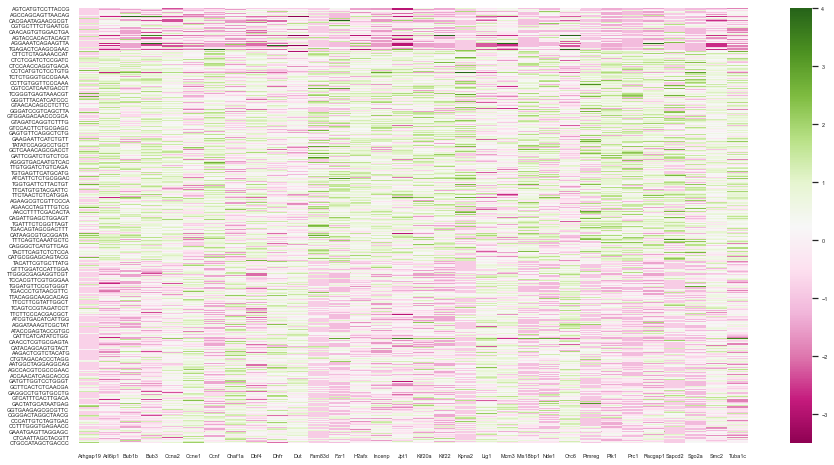

In [169]:
# plot the heatmap
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale=.5)
sns.heatmap(data_hmap, cmap='PiYG', vmax=4) # nice